In [1]:
import numpy as np
from scipy.stats import uniform_direction
import matplotlib.pyplot as plt
import ot
import cvxpy as cp
import time
import os

In [2]:
class minimum_distance_estimator:

    def __init__(self, dimension, radius, covariate_samples, dependent_samples):

        self.dimension = dimension
        self.radius = radius
        self.covariate_samples = covariate_samples
        self.dependent_samples = dependent_samples

        self.sample_size, _ = np.shape(covariate_samples.T)
        self.NN_parameter = int(np.ceil(self.sample_size ** (self.dimension / (2 * self.dimension - 1))))


    #Main block coordinate descent algorithm
    def block_coordinate_descent(self, iteration, unit_sample_size):

        unit_vector_samples, projected_NN_samples = self.NN_projection(unit_sample_size)
        
        descent_vector = self.initialize_vector()
        
        for iter in range(iteration):
            descent_vector = self.convex_iteration(descent_vector, projected_NN_samples, unit_vector_samples)
            
        return descent_vector


    #Main approximate block coordinate descent algorithm
    def approximate_block_coordinate_descent(self, iteration, unit_sample_size):

        unit_vector_samples, projected_NN_samples = self.NN_projection(unit_sample_size)
        
        descent_vector = self.initialize_vector()
        
        for iter in range(iteration):
            descent_vector = self.objective_vector(descent_vector, projected_NN_samples, unit_vector_samples) * self.dimension / unit_sample_size
            descent_vector = self.vector_projection(descent_vector)

        return descent_vector


    #Computation of projected sample values
    def NN_projection(self, unit_sample_size):

        unit_vector_samples = uniform_direction.rvs(dim = self.dimension, size = unit_sample_size).T
        projected_NN_samples = np.zeros((self.NN_parameter, unit_sample_size))
    
        for iter in range(unit_sample_size):
            
            unit_vector = unit_vector_samples[:, iter].reshape(-1, 1)

            projected_covariates = unit_vector.T @ self.covariate_samples
            NN_covariates_index =  np.argsort(projected_covariates)[0, -self.NN_parameter:]
            projected_NN_samples[:, iter] =  np.sort((np.diag(self.dependent_samples[NN_covariates_index]) @ self.covariate_samples[:, NN_covariates_index].T @ unit_vector).reshape((-1, )))
        
        return unit_vector_samples, projected_NN_samples

    #Computation of initial vector
    def initialize_vector(self):
        initial_vector = uniform_direction.rvs(dim = self.dimension, size = self.NN_parameter).T  * self.radius 
        initial_vector = initial_vector @ (np.diag(np.random.uniform(size = self.NN_parameter) ** (1 / self.dimension)))
        return initial_vector


    #Computation of vector for minimization of objective 
    def objective_vector(self, descent_vector, projected_NN_samples, unit_vector_samples):
        
        unit_sample_size = np.shape(unit_vector_samples)[1]
        return_vector = np.zeros((self.dimension, self.NN_parameter))

        for unit_iter in range(unit_sample_size):

            descent_sorted_index = np.argsort(unit_vector_samples[:, unit_iter].T @ descent_vector)
            
            for return_iter in range(self.NN_parameter):
                index = descent_sorted_index[return_iter]
                return_vector[:, index] += projected_NN_samples[return_iter , unit_iter] * unit_vector_samples[:, unit_iter]
        return return_vector


    #Iteration based on the convex optimization solution of the objective function for original algorithm
    def convex_iteration(self, descent_vector, projected_NN_samples, unit_vector_samples):
        
        unit_sample_size = np.shape(unit_vector_samples)[1]

        unit_sample_matrix = np.zeros((self.dimension, self.dimension))
        for iter in range (unit_sample_size):
            unit_sample = unit_vector_samples[:, iter].reshape((self.dimension, 1))       
            unit_sample_matrix += unit_sample @ unit_sample.T
        unit_sample_matrix = np.linalg.inv(unit_sample_matrix)

        objective_vector = self.objective_vector(descent_vector, projected_NN_samples, unit_vector_samples)
        product_objective_vector = unit_sample_matrix @ objective_vector

        return_vector = np.zeros((self.dimension, self.NN_parameter))

        for iter in range(self.NN_parameter):
            
            return_column_vector = cp.Variable((self.dimension, 1))
            set_constraints = [cp.norm(return_column_vector, 2) <= self.radius]

            convex_function = cp.matrix_frac(return_column_vector - product_objective_vector[:, iter].reshape((self.dimension, 1)),  unit_sample_matrix)
            convex_objective = cp.Minimize(convex_function)

            problem = cp.Problem(objective = convex_objective, constraints = set_constraints)
            problem.solve(solver = cp.SCS)
            return_vector[:, iter] = return_column_vector.value.reshape(self.dimension, )
            
        return return_vector


    #Projection of vector in the approximate algorithm
    def vector_projection(self, descent_vector):

        projected_vector = np.zeros((self.dimension, self.NN_parameter))
        for iter in range (self.NN_parameter):
            if np.linalg.norm(descent_vector[:, iter]) > self.radius:
                projected_vector[:, iter] = descent_vector[:, iter] / np.linalg.norm(descent_vector[:, iter]) * self.radius               
            else: 
                projected_vector[:, iter] = descent_vector[:, iter]
        
        return projected_vector


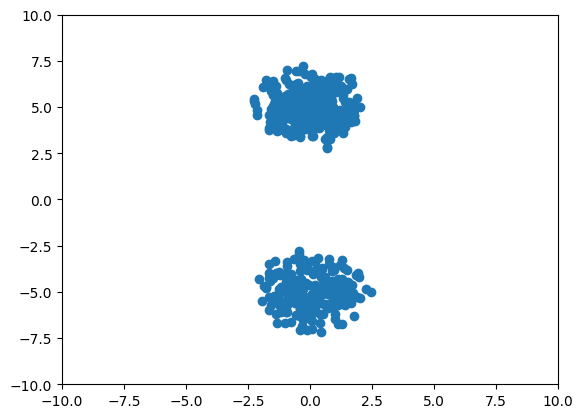

In [3]:
covariate_samples = np.load(os.getcwd() + "\\covariate_samples\\spherical_covariate_samples_5_500.npy")
coefficient_samples = np.load(os.getcwd() + "\\coefficient_samples\\spherical_coefficient_samples_5_500.npy")
dependent_samples = np.load(os.getcwd() + "\\dependent_samples\\spherical_dependent_samples_5_500.npy")
plt.plot(coefficient_samples[0,:], coefficient_samples[1,:], 'o')
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.show()

0
10
20
30
40
50
60
70
80
90
2.2650957107543945
0.9403713596863391


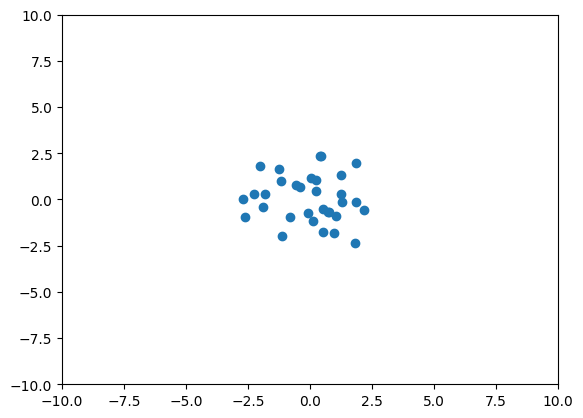

In [4]:
estimator = minimum_distance_estimator(5, 10, covariate_samples, dependent_samples)

iteration = 100
estimation_array = np.zeros((estimator.dimension * iteration, estimator.NN_parameter))
time_array = np.zeros(iteration)
distance_array = np.zeros(iteration)

for iter in range(iteration):
    if iter % 10 == 0:
        print(iter)
    time_start = time.time()
    estimation = estimator.block_coordinate_descent(20, 50)
    time_end = time.time()
    duration = time_end - time_start
    
    estimation_array[estimator.dimension * iter : estimator.dimension * (iter + 1), : ] = estimation
    time_array[iter] = duration
    distance_array[iter] = ot.sliced.sliced_wasserstein_distance(estimation.T, coefficient_samples.T, n_projections= 100, p = 2)

np.save(os.getcwd() + "\\estimation_data\\original_estimation_spherical_5_500", estimation_array)
np.save(os.getcwd() + "\\time_data\\original_time_spherical_5_500", time_array)
np.save(os.getcwd() + "\\distance_data\\original_distance_spherical_5_500", distance_array)

print(time_array[-1])
print(distance_array[-1])
plt.plot(estimation_array[-2, :], estimation_array[-1, :], 'o')
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.show()

0
10
20
30
40
50
60
70
80
90
1.083359956741333
0.9642126608248152


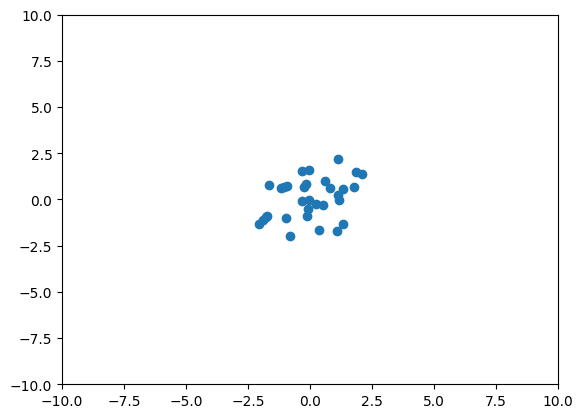

In [5]:
estimator = minimum_distance_estimator(5, 10, covariate_samples, dependent_samples)

iteration = 100
estimation_array = np.zeros((estimator.dimension * iteration, estimator.NN_parameter))
time_array = np.zeros(iteration)
distance_array = np.zeros(iteration)

for iter in range(iteration):
    if iter % 10 == 0:
        print(iter)
    time_start = time.time()
    estimation = estimator.approximate_block_coordinate_descent(20, 1000)
    time_end = time.time()
    duration = time_end - time_start
    
    estimation_array[estimator.dimension * iter : estimator.dimension * (iter + 1), : ] = estimation
    time_array[iter] = duration
    distance_array[iter] = ot.sliced.sliced_wasserstein_distance(estimation.T, coefficient_samples.T, n_projections= 100, p = 2)

np.save(os.getcwd() + "\\estimation_data\\approximate_estimation_spherical_5_500", estimation_array)
np.save(os.getcwd() + "\\time_data\\approximate_time_spherical_5_500", time_array)
np.save(os.getcwd() + "\\distance_data\\approximate_distance_spherical_5_500", distance_array)

print(time_array[-1])
print(distance_array[-1])
plt.plot(estimation_array[-2, :], estimation_array[-1, :], 'o')
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.show()